<a href="https://colab.research.google.com/github/Stefano-t/bioinf-lab/blob/main/k562_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install crr_labels epigenomic_dataset \
 ucsc_genomes_downloader cache_decorator minepy &> /dev/null && echo "done"

done


In [2]:
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset import load_epigenomes

In [3]:
cell_line = "K562"
genome_assembly = "hg38"
window_size = 256

promoters_epigenomes, promoters_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "promoters",
    window_size = window_size,
    root = "datasets"
)

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "enhancers",
    window_size = window_size,
    root = "datasets"
)

In [4]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes,
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels,
}

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

n_splits = 10
test_size = 0.2
random_state = 1902

stratified_split = StratifiedShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

regression_split = ShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

In [8]:
def describe_dataset(
    X: pd.DataFrame,
    y: pd.DataFrame
):
    """Perform a quick report for some relevant information in the dataset.

    Parameters
    ---------- 
    X: pd.DataFrame
        The dataframe to describe.
    y: pd.DataFrame
        The labels to describe.
    """
    print(X.describe())
    print(X[:5])
    print(y.describe())
    print(y[:5])
    print("="*30, "Feature Sample ration", "="*30)
    print(f"Features/Samples ratio is: {X.shape[0] / X.shape[1]}")
    print("="*30, "NaN count", "="*30)
    print(f"Total NaN values: {X.isna().values.sum()}/{X.values.size}")
    print(f"Max NaN in a row: {X.isna().sum(axis=1).max()}/{X.shape[1]}")
    print(f"Max NaN in a feature: {X.isna().sum().max()}/{X.shape[0]}")   

In [9]:
for region, X in epigenomes.items():
   print(f"{region}") 
   describe_dataset(X, labels[region])
   print("|"*80)

promoters
chrom         SMAD5         NCOA2  ...         NCOA1          KLF1
count  99881.000000  99881.000000  ...  99881.000000  99881.000000
mean       2.238571      0.657735  ...      0.699335      1.298927
std        2.650387      0.930009  ...      0.462811      1.111308
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.620000      0.410000  ...      0.370000      0.660000
50%        1.100000      0.600000  ...      0.650000      1.040000
75%        3.070000      0.800000  ...      0.970000      1.620000
max       55.770000     38.470000  ...     11.170000     46.240000

[8 rows x 429 columns]
chrom                             SMAD5  NCOA2  ZNF23  ...  NCOR1  NCOA1  KLF1
chrom chromStart chromEnd strand                       ...                    
chr1  628964     629220   +        0.14   1.00   0.19  ...   1.40   1.74  1.59
      629013     629269   +        0.14   0.97   0.20  ...   1.42   1.63  1.21
      629642     629898   +        0.00   0.11 

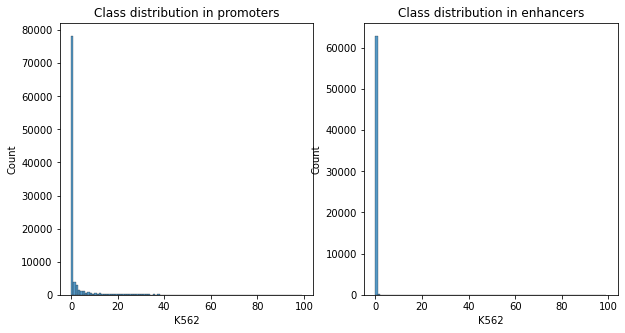

In [43]:
# class balance

import seaborn as sbn

_, axes = plt.subplots(ncols=2, figsize=(10, 5))

#for axis, (region, y) in zip(axes.ravel(), labels.items()):
    #y.hist(ax=axis, bins=10)
    #axis.set_title(f"Classes count in {region}")

bins = np.arange(0, 100, 1)

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    sbn.histplot(data=y, x=cell_line, bins=bins, ax=axis)
    axis.set_title(f"Class distribution in {region}")

In [44]:
def drop_constant_features(X: pd.DataFrame) -> (pd.DataFrame, bool):
    """Return a DataFrame without constant features in in.

    Parameters
    ----------------
    X: pd.DataFrame
        The dataframe to process.

    Returns
    ----------------
    A tuple with the new DataFrame and a boolean value to point out if the
    new DataFrame is distinct from the input one.
    """
    new_X = X.loc[:, (X != X.iloc[0]).any()]
    return (new_X, new_X.shape[1] != X.shape[1])

In [45]:
for region, X in epigenomes.items():
    X_new, ok = drop_constant_features(X)
    if ok:
        epigenomes[region] = X_new
    else:
        print(f"{region} doesn't have costant features.")

promoters doesn't have costant features.
enhancers doesn't have costant features.


In [46]:
def impute_with_median(X: pd.DataFrame) -> pd.DataFrame:
    return X.fillna(X.median())

In [47]:
for region, X in epigenomes.items():
   epigenomes[region] = impute_with_median(X) 

In [48]:
from sklearn.preprocessing import RobustScaler

def robust_scaler(X: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(X.values),
        columns=X.columns,
        index=X.index
    )

In [49]:
for region, X in epigenomes.items():
   epigenomes[region] = robust_scaler(X) 

# Verify output correlation

In [50]:
from scipy.stats import pearsonr

uncorrelated_features_with_output = {
    region: set()
    for region in epigenomes
}

for region, X in epigenomes.items():
    print("="*20, region.upper(), "="*20)
    for feature in tqdm(
        X.columns,
        desc=f"Running Person test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = pearsonr(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        if p_value > 0.01:
            print(f"Feature {feature} has no correlation with the output.")
            uncorrelated_features_with_output[region].add(feature)

print(uncorrelated_features_with_output)

==================== PROMOTERS ====================


Feature ZKSCAN3 has no correlation with the output.
Feature ZNF785 has no correlation with the output.
Feature U2AF2 has no correlation with the output.
Feature RBM17 has no correlation with the output.
Feature ARID2 has no correlation with the output.
Feature ZBTB33 has no correlation with the output.
Feature ZNF408 has no correlation with the output.
Feature RFX1 has no correlation with the output.
Feature EHMT2 has no correlation with the output.
Feature ZBTB8A has no correlation with the output.
Feature MIER1 has no correlation with the output.
Feature NCOA4 has no correlation with the output.
Feature ZNF512 has no correlation with the output.
Feature KLF10 has no correlation with the output.
Feature ZNF319 has no correlation with the output.
Feature PTRF has no correlation with the output.
Feature SMARCA5 has no correlation with the output.
Feature NCOA1 has no correlation with the output.
==================== ENHANCERS ====================


Feature STAG1 has no correlation with the output.
Feature XRCC3 has no correlation with the output.
Feature ILK has no correlation with the output.
Feature ZNF830 has no correlation with the output.
Feature HNRNPH1 has no correlation with the output.
Feature RBM17 has no correlation with the output.
Feature NR0B1 has no correlation with the output.
Feature whole-genome shotgun bisulfite sequencing has no correlation with the output.
Feature ZNF778 has no correlation with the output.
Feature H4K20me1 has no correlation with the output.
Feature SNRNP70 has no correlation with the output.
Feature CEBPG has no correlation with the output.
Feature PCBP2 has no correlation with the output.
Feature ATF2 has no correlation with the output.
Feature MCM2 has no correlation with the output.
Feature RFX1 has no correlation with the output.
Feature FOXJ3 has no correlation with the output.
Feature ZBTB8A has no correlation with the output.
Feature SRSF7 has no correlation with the output.
Feature Z

In [51]:
from scipy.stats import spearmanr

for region, X in epigenomes.items():
    print("="*20, region.upper(), "="*20)
    for feature in tqdm(
        X.columns,
        desc= f"Running Spearman test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = spearmanr(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        if p_value > 0.01:
            print(f"Feature {feature} has no correlation with the output {correlation}.")
            uncorrelated_features_with_output[region].add(feature)

print(uncorrelated_features_with_output)

==================== PROMOTERS ====================


Feature ZNF785 has no correlation with the output 0.00226152461950466.
Feature ARHGAP35 has no correlation with the output 0.0059617930005142344.
==================== ENHANCERS ====================


Feature SUZ12 has no correlation with the output 0.004583850538435079.
Feature U2AF2 has no correlation with the output 0.008261248556096393.
Feature RBM17 has no correlation with the output 0.006786566984658262.
Feature FOXJ3 has no correlation with the output -0.0035543247658476034.
Feature SRSF7 has no correlation with the output 0.00019059684242344712.
Feature DLX4 has no correlation with the output 0.0012562137044762349.
Feature EWSR1 has no correlation with the output 0.0020771158738122617.
Feature TSC22D4 has no correlation with the output 0.00941262848082613.
Feature MCM7 has no correlation with the output 0.010071824629510751.
{'promoters': {'MIER1', 'ZNF319', 'ZNF785', 'KLF10', 'NCOA4', 'NCOA1', 'ARID2', 'SMARCA5', 'ZBTB8A', 'ARHGAP35', 'ZKSCAN3', 'ZBTB33', 'ZNF512', 'RFX1', 'U2AF2', 'ZNF408', 'RBM17', 'PTRF', 'EHMT2'}, 'enhancers': {'CEBPG', 'ZNF280A', 'PCBP2', 'NR0B1', 'SNRNP70', 'SRSF7', 'FOXA1', 'ATF2', 'STAG1', 'ZNF318', 'YBX1', 'HNRNPH1', 'SAFB2', 'ZBTB8A', 'SUZ12', 'ZN

In [ ]:
from minepy import MINE

for region, X in epigenomes.items():
    for feature in tqdm(
        uncorrelated_features_with_output[region],
        desc = f"Running MINE test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        mine = MINE()
        mine.compute_score(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        score = mine.mic()
        if score >= 0.05:
            uncorrelated_features_with_output[region].remove(feature)
        else:
            print(region, feature, score)

print(uncorrelated_features_with_output)

promoters ZBTB8A 0.013868199773903946
promoters RFX1 0.030841217924228503
promoters ZNF512 0.013577929456178393
promoters ZBTB33 0.034617713095646
promoters PTRF 0.011167015589385935
promoters U2AF2 0.04401463313911483
promoters KLF10 0.013898726991151716
promoters MIER1 0.03447048689016187
promoters RBM17 0.02333391158780632
promoters ZNF408 0.010693048115547105
promoters SMARCA5 0.015421008134788953
promoters NCOA4 0.011425141274769497
promoters NCOA1 0.019660240653536918
promoters ZKSCAN3 0.01207067423363108
promoters ZNF319 0.02073232670015601
promoters ARHGAP35 0.01689024805695061
promoters ZNF785 0.010328123834868636
promoters EHMT2 0.02357997917411199
promoters ARID2 0.020140227969308377


enhancers ZNF830 0.004276624258902587
enhancers MCM7 0.004591594513259929
enhancers ZBTB8A 0.00456118536356291
enhancers DLX4 0.004417119507728877
enhancers RFX1 0.017244583532098706
enhancers MCM2 0.005882175953094093
enhancers whole-genome shotgun bisulfite sequencing 0.01543081217089772
enhancers U2AF2 0.0067433624260091005
enhancers TSC22D4 0.004412036375980728
enhancers RBM17 0.005098695020370129
enhancers FOXA1 0.005179187854491389
enhancers YBX1 0.004733752143321934
enhancers FOXJ3 0.005475335153331171
enhancers H4K20me1 0.009335786258020484
enhancers EWSR1 0.004799756297077799
enhancers ZNF318 0.005197782427301565
enhancers SAFB2 0.005277694525388302
enhancers NR0B1 0.004007583986925275
enhancers PCBP2 0.0067870565985254355
enhancers STAG1 0.006835763406215087
enhancers HNRNPH1 0.005892977277928196
enhancers SUZ12 0.00736284746927227
enhancers XRCC3 0.004630206157312691
enhancers ILK 0.005337826201466052
enhancers ATF2 0.020194054607857188
enhancers ZNF280A 0.006815452312017244

In [ ]:
for region, X in epigenomes.items():
    epigenomes[region] = X.drop(columns=[
        c
        for c in uncorrelated_features_with_output[region]
        if c in X.columns                     
    ])

In [ ]:
for _, X in epigenomes.items():
    print(X.shape)

(99881, 410)
(63285, 398)


# Feature Correlation

In [99]:
from scipy.stats import entropy
from typing import Dict

def features_correlation(
    X: pd.DataFrame,
    region: str,
    p_value_threshold: float = 0.01,
    correlation_threshold: float = 0.95
) -> Dict:
    scores = {
        region: []
    }

    for i, feature_1 in tqdm(
        enumerate(X.columns),
        total = len(X.columns),
        desc = f"Running tests for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(
                X[feature_1].values.ravel(),
                X[feature_2].values.ravel()
            )
            scores[region].append((correlation, feature_1, feature_2))
    #        if p_value < p_value_threshold and np.abs(correlation) > correlation_threshold:
    #            print(f"High correlation (Pearson): {feature_1} with {feature_2} ({correlation})")
    #            if entropy(X[feature_1]) > entropy(X[feature_2]):
    #                high_correlation[region].add(feature_2)
    #            else:
    #                high_correlation[region].add(feature_1)
    
    return scores

In [100]:
result = []

for region, X in epigenomes.items():
    result.append(features_correlation(X, region))

In [102]:
r = {**result[0], **result[1]}
r

{'enhancers': [(0.12216179358227203, 'SMAD5', 'NCOA2'),
  (0.23387066543016002, 'SMAD5', 'ZNF23'),
  (0.21741304296109681, 'SMAD5', 'NR2F6'),
  (0.1668485846716487, 'SMAD5', 'CEBPZ'),
  (0.14114541719816062, 'SMAD5', 'SNIP1'),
  (0.2889744002510357, 'SMAD5', 'ZBTB7A'),
  (0.2256685478634426, 'SMAD5', 'ZNF133'),
  (0.17972508916098384, 'SMAD5', 'NRF1'),
  (0.5573331744297135, 'SMAD5', 'TAF1'),
  (0.10293834723716644, 'SMAD5', 'STAG1'),
  (0.32905301314915514, 'SMAD5', 'ZFX'),
  (0.24693286556164362, 'SMAD5', 'STAT5A'),
  (0.09362783729250382, 'SMAD5', 'E2F1'),
  (0.23615294387891728, 'SMAD5', 'H2AFZ'),
  (0.10381907129123082, 'SMAD5', 'TAL1'),
  (0.2520366438851249, 'SMAD5', 'NFRKB'),
  (0.23487475643800373, 'SMAD5', 'HNRNPUL1'),
  (0.3112908122879273, 'SMAD5', 'SKIL'),
  (0.073441543311644, 'SMAD5', 'RBM34'),
  (0.2199940162832975, 'SMAD5', 'ZBTB11'),
  (0.5167779728854784, 'SMAD5', 'RBFOX2'),
  (0.2325052583186956, 'SMAD5', 'ZNF175'),
  (0.2262090389639531, 'SMAD5', 'GATA2'),
  (0.075